In [372]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [378]:
print('pandas=='+pd.__version__)
print('numpy=='+np.__version__)
print('seaborn=='+sns.__version__)
print('matplotlib=='+matplotlib.__version__)
print('sklearn=='+sklearn.__version__)
print('opencv-python=='+cv2.__version__)

pandas==1.1.0
numpy==1.19.1
seaborn==0.10.1
matplotlib==3.3.1
sklearn==0.23.2
opencv-python==4.4.0


## data checking

In [2]:
df = pd.read_csv('ds_challenge_train.csv',low_memory=False,header=None)

<AxesSubplot:xlabel='0', ylabel='count'>

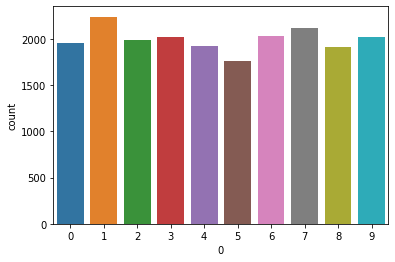

In [3]:
sns.countplot(df[0])

In [4]:
##### data look balance enough

In [5]:
#### check any NA
df.isna().any().any()

False

In [6]:
### no NAN for the missing

In [7]:
np.unique(df[0],return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1962, 2243, 1989, 2021, 1924, 1761, 2039, 2126, 1912, 2023]))

In [8]:
np.array(df.loc[0][1:])
## there is a string columns in here

array([0, 0, '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '24', '67', '67', '18', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '131', '252', '252', '66', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '159', '25

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 785 entries, 0 to 784
dtypes: int64(383), object(402)
memory usage: 119.8+ MB


In [10]:
#### int64
### 402 objects ????

In [11]:
## try parse
for i in df.columns:
    try:
        df[i] = df[i].astype(int)
    except Exception as e:
        print(e)
        break

invalid literal for int() with base 10: '-'


In [12]:
##### parse fail
##### check - 
#### get row where value cant be parse
def getNotANumber(d):
    try:
        float(d)
        return False
    except: 
        return True

In [13]:
#### get not a number index
nanInd = []
for i in df.columns:
    nanInd += list(df[df[i].apply(getNotANumber)].index)

In [14]:
nanInd= set(nanInd)

In [15]:
nonNumberdf = df.loc[nanInd].copy()

<AxesSubplot:xlabel='0', ylabel='count'>

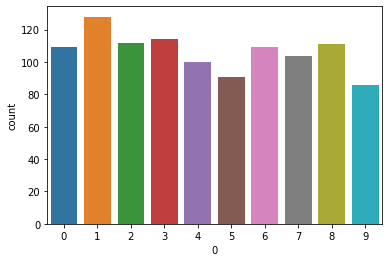

In [16]:
sns.countplot(nonNumberdf[0])

In [17]:
r = 0

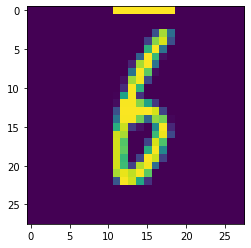

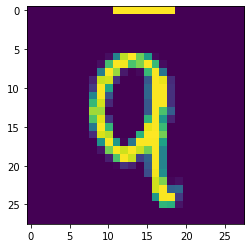

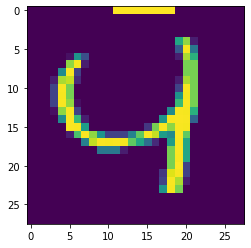

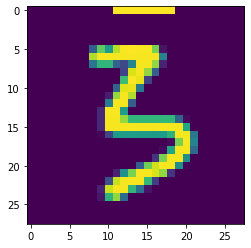

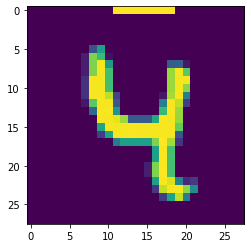

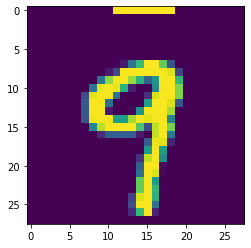

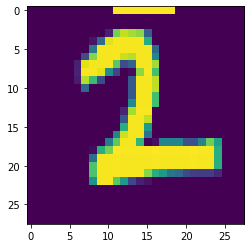

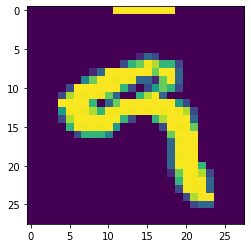

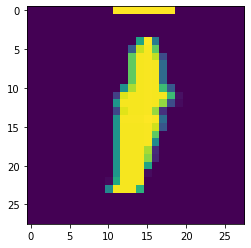

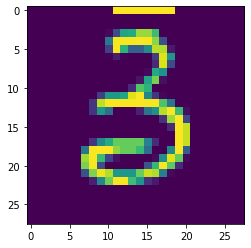

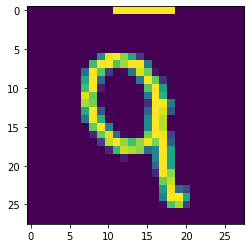

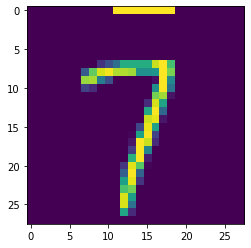

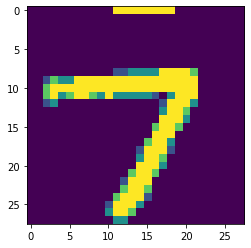

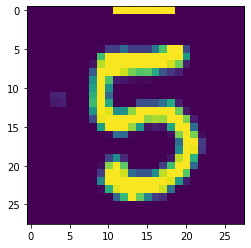

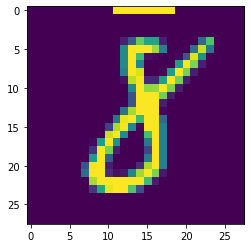

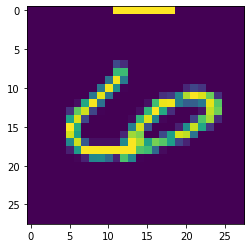

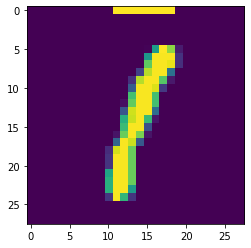

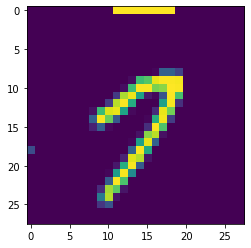

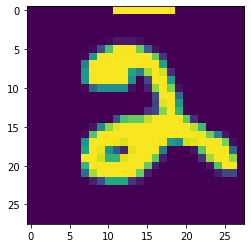

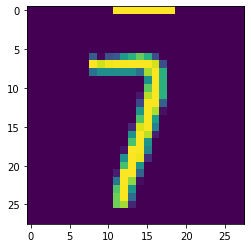

In [18]:
for i in range(r,r+20):
    plt.imshow(np.array(nonNumberdf.iloc[i].astype(str).str.replace('-','255').astype(int)[1:]).reshape(28,28))
    plt.show()
r+=20

In [19]:
### after looking throught missing on the top and mostly can still be tell the number even with 0 fill except where almost half of the picture is missing
### with limited time and resources let just drop the one that was about half missing
### other option of dealing KNN, Variational Auto Encode (should be the most effective one)

In [20]:
def countDash(d):
    ret = 0
    for i in d:
        if(i=='-'):
            ret+=1
    return ret

In [21]:
nonNumberdf['missingCount'] = nonNumberdf.apply(countDash,axis=1)

<AxesSubplot:xlabel='missingCount'>

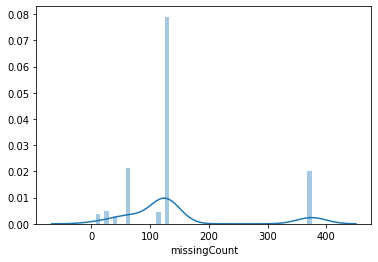

In [22]:
sns.distplot(nonNumberdf['missingCount'] )

<AxesSubplot:xlabel='missingCount', ylabel='count'>

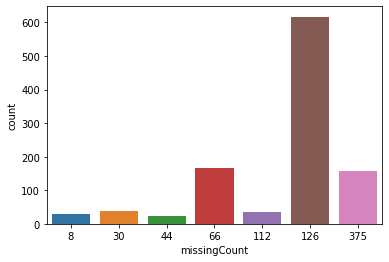

In [23]:
sns.countplot(nonNumberdf['missingCount'] )

In [24]:
## morethan~25% missing drop
dropInd = nonNumberdf[nonNumberdf['missingCount']>200].index

In [25]:
### check if there is somthing morethan 255
df.describe().loc['max'].describe()
# (df[df.columns[1:]]>255).any().any()

count    383.000000
mean     217.281984
std       85.791168
min        0.000000
25%      254.000000
50%      255.000000
75%      255.000000
max      255.000000
Name: max, dtype: float64

In [26]:
df = df.drop(dropInd)

In [27]:
### parse and replace
for i in df.columns:
    try:
        df[i] = df[i].astype(int)
    except:
        df[i] = df[i].str.replace('-','0').astype(int)

In [28]:
df.to_csv('droppedTrainingData.csv',index=False)

## Preprocess and Modeling

In [147]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

In [42]:
y = df[0]
X = df.drop(0,axis=1)
## normalize color Value
X = X/255

In [45]:
#### Splitting #### (FirstTime)
# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,stratify=y)
# with open('train_test_splittedData.pkl', 'wb') as file:
#     pickle.dump([X_train, X_test, y_train, y_test],file)

#### for repetition purpose Load the file ###
with open('train_test_splittedData.pkl', 'rb') as file:
    X_train, X_test, y_train, y_test = pickle.load(file)

### no preprocessing 

In [48]:
### linear SVM

In [49]:
lsvmSearch = GridSearchCV(SVC(kernel='linear')
                          ,{'C':[0.01,0.1,1,10,100]}
                          ,cv=10)
lsvmSearch.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [52]:
lsvmSearch.best_score_

0.9301338091768923

In [54]:
lsvmSearch.best_params_

{'C': 0.1}

In [55]:
lsvmSearch.score(X_test,y_test)

0.9327286470143613

In [56]:
##### end linear SVM

In [57]:
###### rbf SVM

In [63]:
rsvmSearch = GridSearchCV(SVC(kernel='rbf')
                          ,{'C':[0.01,0.1,1,10,100]}
                          ,cv=10)
rsvmSearch.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=SVC(), param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [67]:
rsvmSearch.best_score_

0.9737920985843733

In [68]:
rsvmSearch.best_params_

{'C': 10}

In [69]:
rsvmSearch.score(X_test,y_test)

0.9712773998488284

In [76]:
#### end RBF SVN

#### summary problem is better fit on non linear kernel #### so this problem probably not in linear space ###

In [145]:
##### predictPipeLine
def preprocessPredData(d):
    ## try change to int
    try:
        ## normalize data
        ret = int(d)/255
        ## value clipping 
        if(d > 1):
            return 1
        if(d < 0):
            return 0
        return ret
    ## if cannot change to 0
    except:
        return 0

def predict(data,model):
    ### pleas pass pandas or nparray
    if( not(isinstance(data, pd.DataFrame) or  isinstance(data, pd.Series) or isinstance(data, np.array))):
        raise ('not pandas or np_array')

    #####
    
    ##process data in this block or use default below

    #####

    #### check dimension
    tmp = np.array(data)
    dims = tmp.ndim

    if(dims == 1):
        try:
            tmp = tmp.reshape(1,784)
        except:
            raise('mismatch Length (default:784)')
    else:
        if(dims !=2):
            raise('data dimension error')
    #### preprocessing data
    tmp = np.vectorize(preprocessPredData)(tmp)
    
    return model.predict(tmp)
###

In [146]:
### test pipe on unprocessed data 
predict(df.drop(0,axis=1).iloc[[0,20]],rsvmSearch)
# predict(df.drop(0),rsvmSearch)
#####


array([6, 9])

## Classify Using PCA

In [153]:
pca = PCA(svd_solver='full')

In [154]:
# set the tolerance to a large value to make the example faster
pipeSVC = SVC(kernel='rbf')
pipe = Pipeline(steps=[('pca', pca), ('SVC', pipeSVC)])

In [156]:
param_grid = {
    'pca__n_components': [0.95,0.99],
    'SVC__C': [0.1,1,10]
}
searchSVCPipe = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=10)
searchSVCPipe.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA(svd_solver='full')),
                                       ('SVC', SVC())]),
             n_jobs=-1,
             param_grid={'SVC__C': [0.1, 1, 10],
                         'pca__n_components': [0.95, 0.99]})

In [157]:
searchSVCPipe.best_params_

{'SVC__C': 10, 'pca__n_components': 0.95}

In [158]:
searchSVCPipe.best_score_

0.9753043065588004

In [161]:
searchSVCPipe.score(X_test,y_test)

0.9750566893424036

In [162]:
with open('SVC97.5Acc_trainedPipe.pkl', 'wb') as file:
    pickle.dump(searchSVCPipe,file)

In [163]:
###########

In [193]:
findBestExplainVariance =  Pipeline(steps=[('pca', PCA(svd_solver='full')), ('SVC', SVC(C=10))])

In [194]:
param_grid = {
    'pca__n_components': [0.8,0.9,0.95],
}
findBestExplainVariance = GridSearchCV(findBestExplainVariance, param_grid, n_jobs=-1,cv=10)
findBestExplainVariance.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA(svd_solver='full')),
                                       ('SVC', SVC(C=10))]),
             n_jobs=-1, param_grid={'pca__n_components': [0.8, 0.9, 0.95]})

In [197]:
findBestExplainVariance.best_score_

0.9776354320922991

In [198]:
findBestExplainVariance.best_params_

{'pca__n_components': 0.8}

In [195]:
findBestExplainVariance.score(X_test,y_test)

0.9755605946082136

In [200]:
findBestExplainVariance.best_estimator_['pca'].transform(df.loc[[0]].drop(0,axis=1)).shape

(1, 44)

In [201]:
##### best explained variance embedding = ~0.8

## end

## deskew preprocessing

#### change tabular to img format

In [313]:
import cv2
def rowTOBWimg(d):
    return np.array(d).reshape(28,28)


In [333]:
## multiply by 255 to get initial value back

In [318]:
X_train['pic'] = (X_train*255).apply(rowTOBWimg,axis=1)

<ipython-input-318-e1b60c9c52cf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pic'] = (X_train*255).apply(rowTOBWimg,axis=1)


In [319]:
X_train_pic = X_train[['pic']]

In [322]:
X_test['pic'] = (X_test*255).apply(rowTOBWimg,axis=1)

<ipython-input-322-c7c9929267e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['pic'] = (X_test*255).apply(rowTOBWimg,axis=1)


In [323]:
X_test_pic = X_test[['pic']]

In [324]:
with open('train_test_splittedData_pic.pkl', 'wb') as file:
    pickle.dump([X_train_pic, X_test_pic, y_train, y_test],file)

#### also save for when doing CNN

#####  tabular to 2d array end

## deskewing start

In [327]:
### by cv2
SZ = 28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img

In [328]:
X_train_pic_deskewed = X_train_pic.copy()
X_train_pic_deskewed['pic'] = X_train_pic_deskewed['pic'].apply(deskew)

In [329]:
X_test_pic_deskewed = X_test_pic.copy()
X_test_pic_deskewed['pic'] = X_test_pic_deskewed['pic'].apply(deskew)

## deskewed end

# flatten for training SVM

In [330]:
X_train_pic_deskewed_flatten = X_train_pic_deskewed.apply(lambda d: d['pic'].flatten(),result_type='expand',axis=1)

In [331]:
X_test_pic_deskewed_flatten = X_test_pic_deskewed.apply(lambda d: d['pic'].flatten(),result_type='expand',axis=1)

In [ ]:
#normalize

In [337]:
X_train_pic_deskewed_flatten = X_train_pic_deskewed_flatten/255
X_test_pic_deskewed_flatten = X_test_pic_deskewed_flatten/255

In [ ]:
#####

In [ ]:
#### test rbf SVM without further processing

In [342]:
deskewedrSVMSearch = GridSearchCV(SVC(kernel='rbf')
                          ,{'C':[1,10,100]}
                          ,cv=10,n_jobs=-1)
deskewedrSVMSearch.fit(X_train_pic_deskewed_flatten,y_train)

GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1, param_grid={'C': [1, 10, 100]})

In [343]:
deskewedrSVMSearch.best_params_

{'C': 10}

In [344]:
deskewedrSVMSearch.best_score_

0.9770684433820763

In [345]:
deskewedrSVMSearch.score(X_test_pic_deskewed_flatten,y_test)
### 98 percent Yeahhhh

0.9805996472663139

In [346]:
confusion_matrix(y_true=y_test,y_pred=deskewedrSVMSearch.predict(X_test_pic_deskewed_flatten))

array([[386,   0,   0,   1,   1,   0,   1,   0,   0,   0],
       [  0, 439,   2,   0,   0,   1,   0,   3,   1,   0],
       [  0,   0, 389,   0,   1,   0,   0,   1,   1,   1],
       [  1,   1,   3, 390,   0,   2,   0,   0,   2,   2],
       [  1,   1,   0,   0, 370,   0,   1,   1,   1,   7],
       [  0,   0,   1,   2,   0, 343,   0,   0,   2,   2],
       [  0,   0,   0,   0,   1,   1, 402,   0,   1,   0],
       [  0,   0,   2,   0,   0,   0,   0, 416,   0,   3],
       [  1,   0,   3,   2,   2,   1,   1,   1, 369,   0],
       [  1,   0,   0,   3,   7,   0,   0,   1,   2, 388]])

### deskewed without PCA end

In [347]:
deskewedPipe = Pipeline(steps=[('pca', PCA(svd_solver='full')), ('SVC', SVC())])
param_grid = {
    'pca__n_components': [0.8,0.9,95,0.99],
    'SVC__C': [1,10]
}
searchDeskewedPipe = GridSearchCV(deskewedPipe, param_grid, n_jobs=-1,cv=10)
searchDeskewedPipe.fit(X_train_pic_deskewed_flatten,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('pca', PCA(svd_solver='full')),
                                       ('SVC', SVC())]),
             n_jobs=-1,
             param_grid={'SVC__C': [1, 10],
                         'pca__n_components': [0.8, 0.9, 95, 0.99]})

In [348]:
searchDeskewedPipe.best_params_

{'SVC__C': 10, 'pca__n_components': 95}

In [349]:
searchDeskewedPipe.best_score_

0.9801553554621221

In [350]:
searchDeskewedPipe.score(X_test_pic_deskewed_flatten,y_test)

0.982111363063744

In [351]:
with open('SVC98.2Acc_trainedDeskewedPipe.pkl', 'wb') as file:
    pickle.dump(searchDeskewedPipe,file)

In [352]:
##### can still search and do pixel jitter to improve performance

In [363]:
### deskewed prediction feeding function 
### or can be merge with previous prediction fuction and add condition to process deskew


##### pipe line ###
### feed in shape (784,)
### feed in shape (*,784)
### reshape into (*,28,28)
### apply deskew and flatten

def predictWithDeskew(data,model):
    ### pleas pass pandas or nparray
    if( not(isinstance(data, pd.DataFrame) or  isinstance(data, pd.Series) or isinstance(data, np.array))):
        raise ('not pandas or np_array')

    #####
    
    ##process data in this block or use default below

    #####

    #### check dimension
    tmp = np.array(data)
    dims = tmp.ndim

    if(dims == 1):
        try:
            tmp = tmp.reshape(1,784)
        except:
            raise('mismatch Length (default:784)')
    else:
        if(dims !=2):
            raise('data dimension error')
    #### preprocessing data
    tmp = np.vectorize(preprocessPredData)(tmp)
    #### to be specific this block ###
    # deskewed part 
    # if(deskew condition): #dont forget indent
    tmp = tmp.reshape(tmp.shape[0],28,28)
    tmp = [deskew(i).flatten() for i in tmp]
    #####################
    return model.predict(tmp)
###

In [364]:
##### pipe line  test ###
# testdata1 = df.drop(0,axis=1).loc[[0,1]]
# predictWithDeskew(testdata1,searchDeskewedPipe)
testdata2 = df.drop(0,axis=1).loc[0]
predictWithDeskew(testdata2,searchDeskewedPipe)

array([6])

In [365]:
with open('train_test_splittedData_pic.pkl', 'rb') as file:
    check = pickle.load(file)

[                                                     pic
 15810  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 15609  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 6747   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 7925   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 9656   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 ...                                                  ...
 10178  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 11024  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 10779  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 19780  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 18895  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 
 [15873 rows x 1 columns],
                                                      pic
 5909   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 17141  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 9631   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
 12034  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0